<a href="https://colab.research.google.com/github/serdarkulakoglu45/Impressed-Current-Cathodic-Protection-pig-station/blob/main/2D_pig_underground_pipeline_CP_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

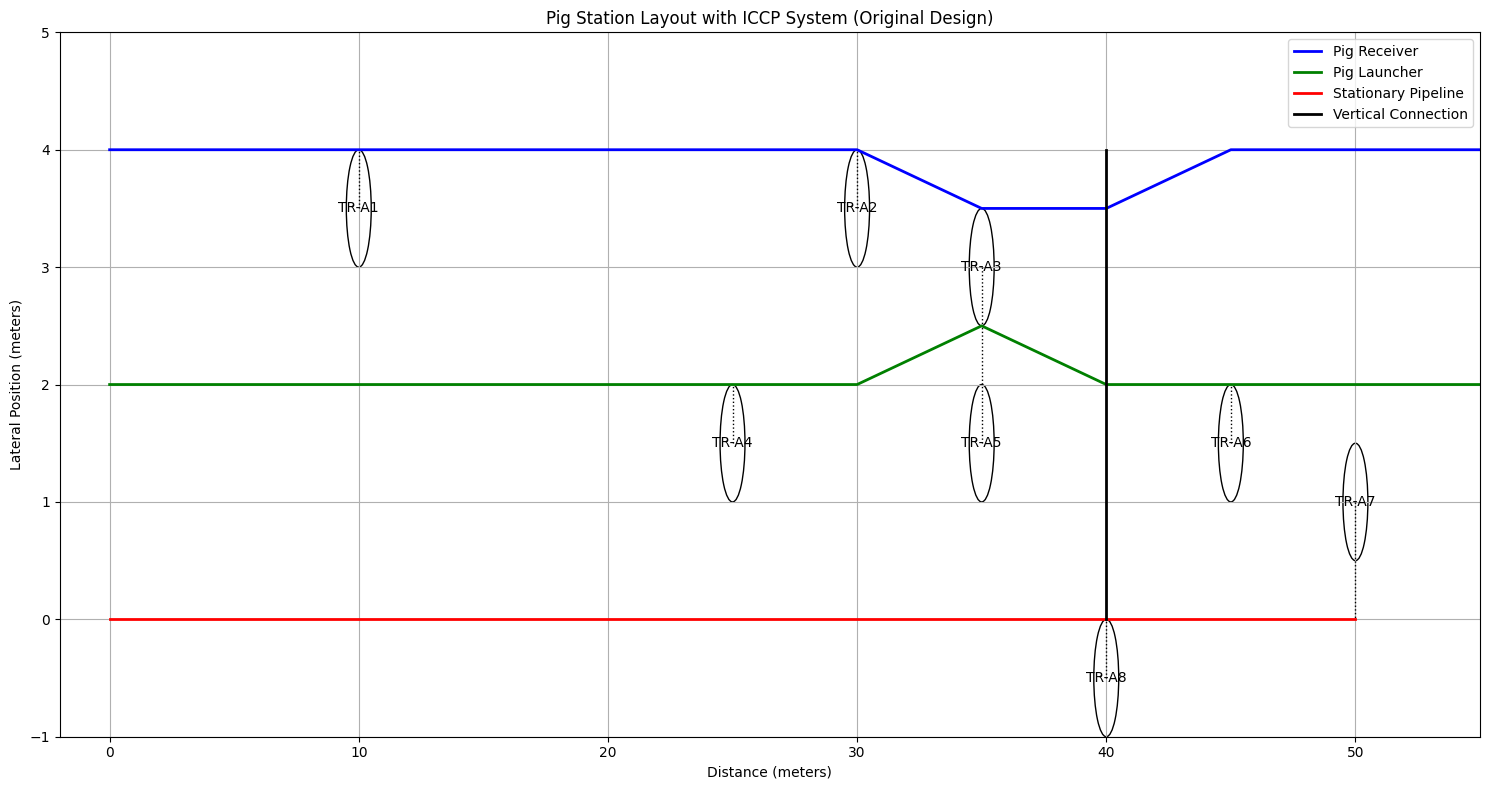

<ipython-input-5-fb64eb1a944b>:201: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  custom_cmap = plt.cm.get_cmap('RdYlBu_r')


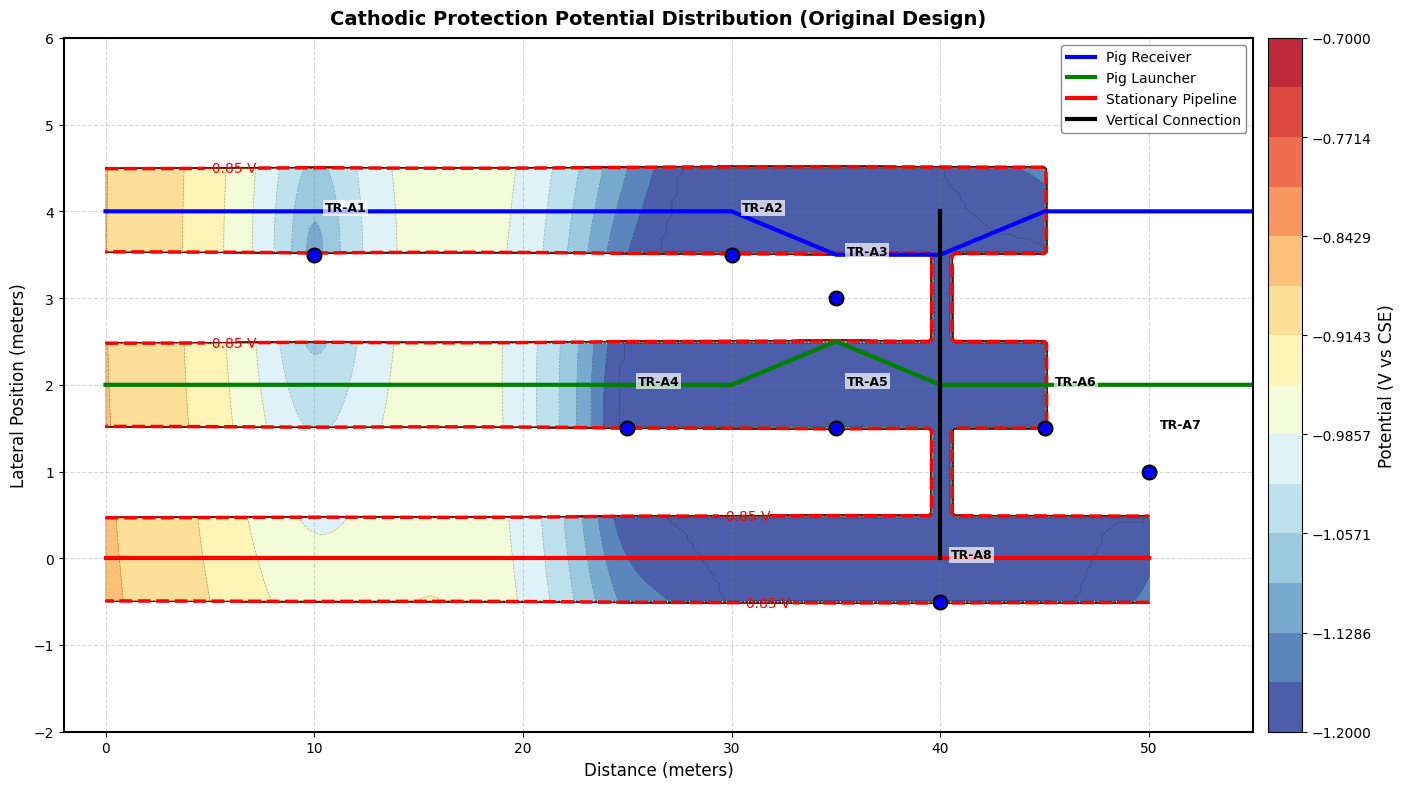

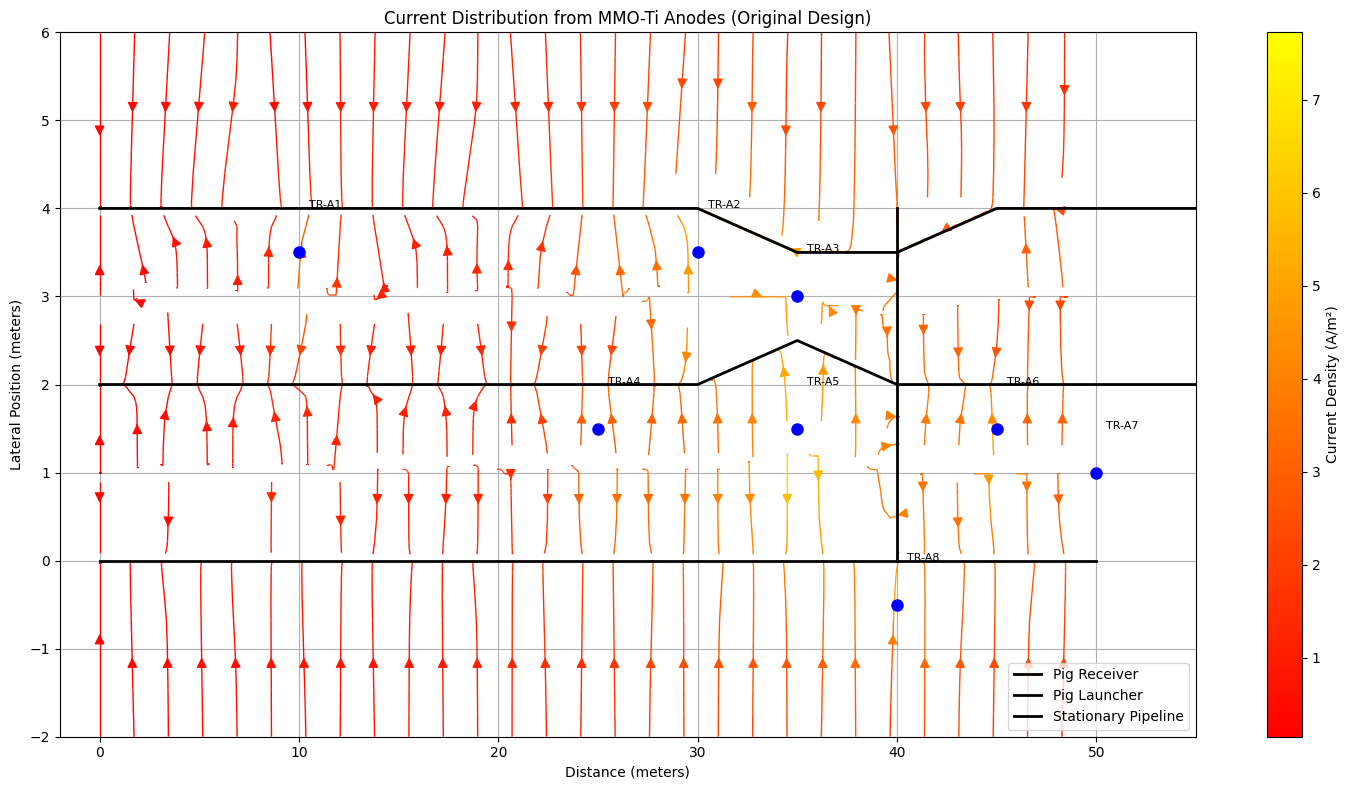

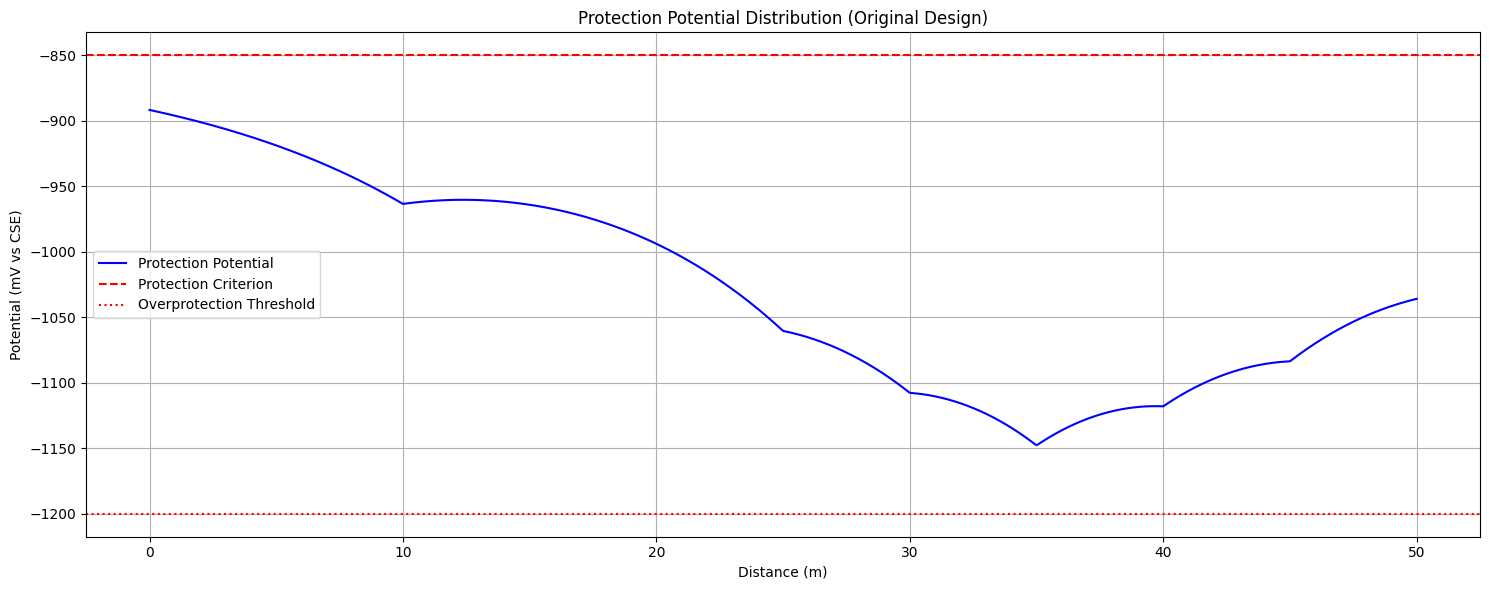


Pipeline Analysis Report (Original Design):
                    Parameter   Value
    Total Pipeline Length (m)    80.0
            Surface Area (m²)   306.4
        Required Current (mA)   919.1
    Soil Resistivity (ohm-cm)    2000
       Coating Efficiency (%)    85.0
             Number of Anodes       8
Average Protection Level (mV) -1028.4
      Optimally Protected (%)   100.0
          Under Protected (%)     0.0
           Over Protected (%)     0.0

Transformer Rectifier Specifications (Original Design):
                Parameter Value
              Voltage (V)  14.4
              Current (A)  1.10
                Power (W)  15.9
                   Anodes     8
Soil Resistivity (ohm-cm)  2000


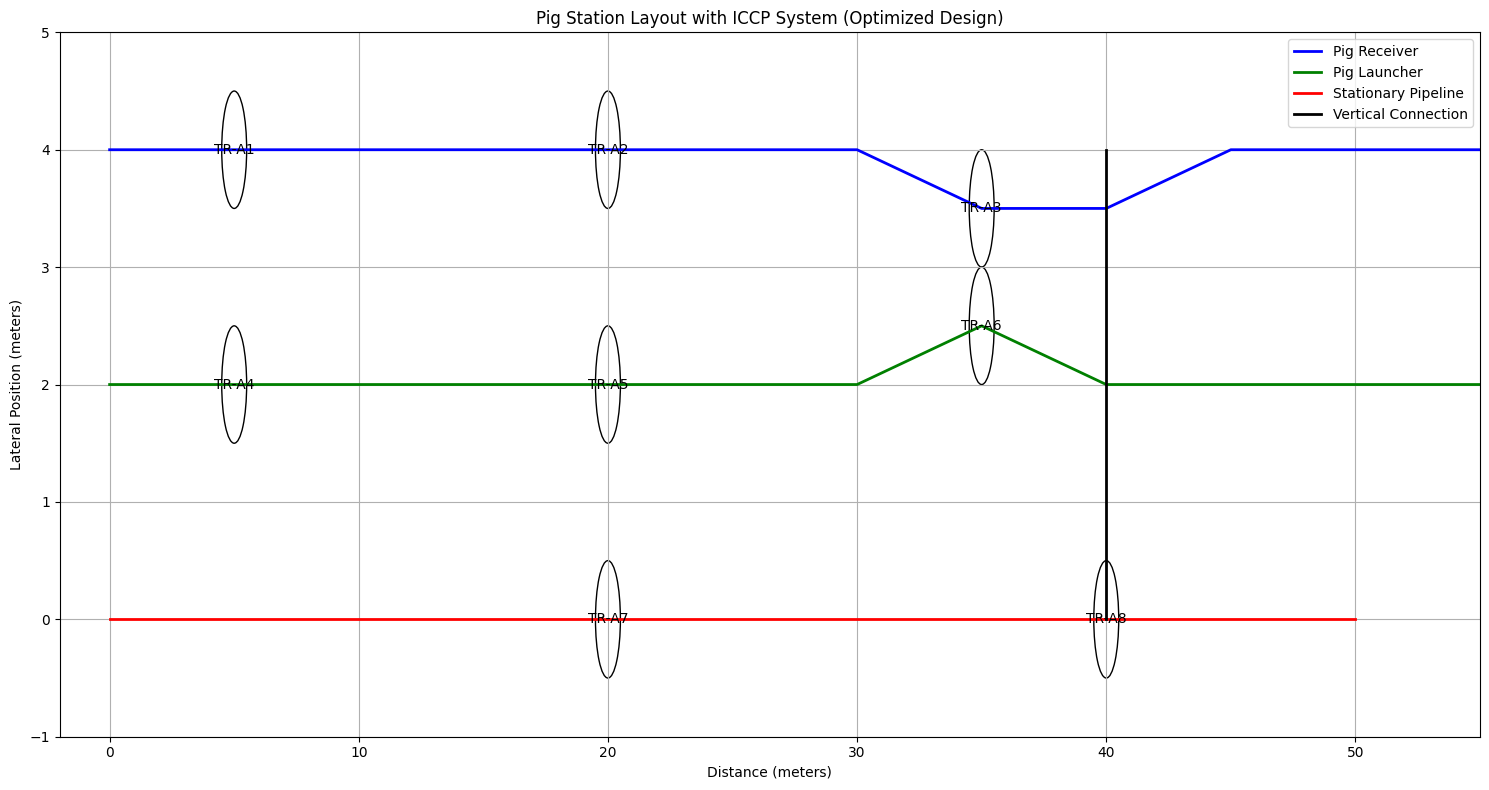

<ipython-input-5-fb64eb1a944b>:201: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  custom_cmap = plt.cm.get_cmap('RdYlBu_r')


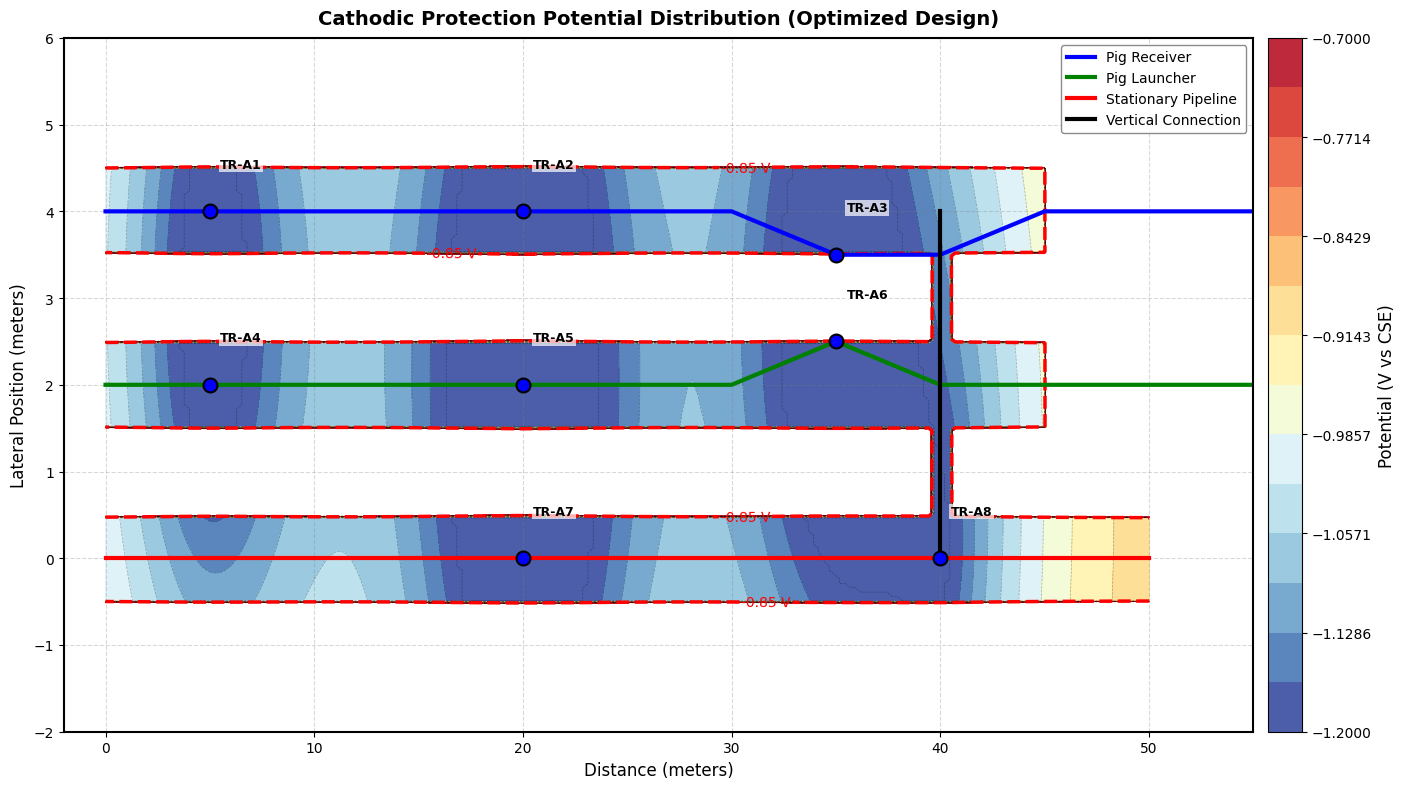

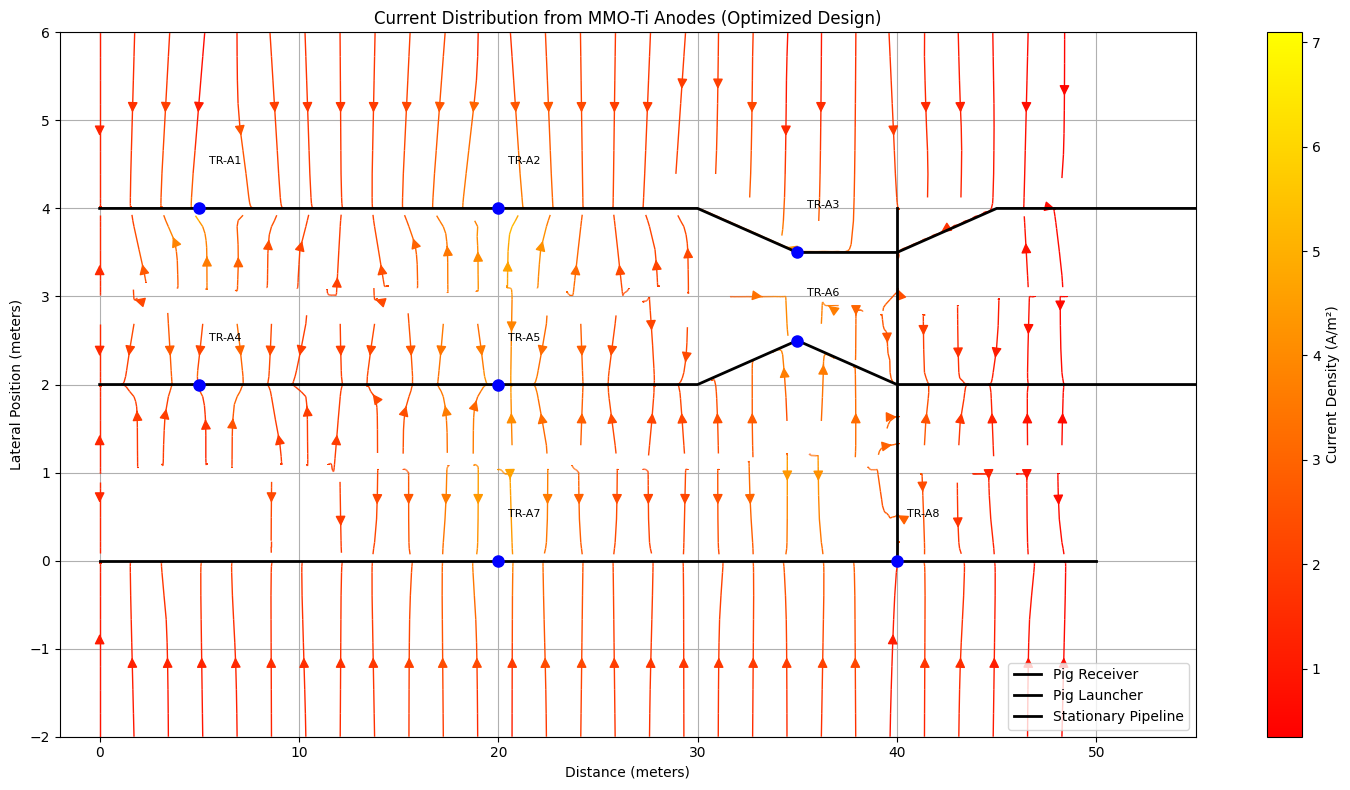

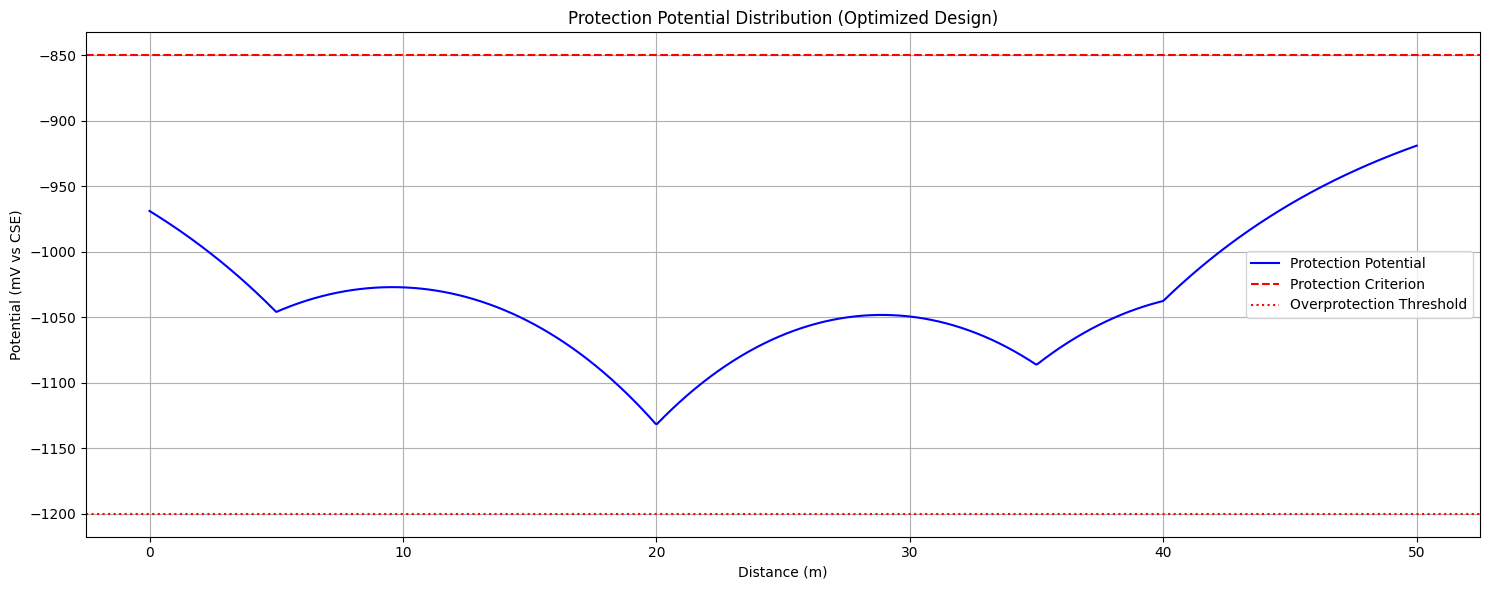


Pipeline Analysis Report (Optimized Design):
                    Parameter   Value
    Total Pipeline Length (m)    80.0
            Surface Area (m²)   306.4
        Required Current (mA)   919.1
    Soil Resistivity (ohm-cm)    2000
       Coating Efficiency (%)    85.0
             Number of Anodes       8
Average Protection Level (mV) -1036.3
      Optimally Protected (%)   100.0
          Under Protected (%)     0.0
           Over Protected (%)     0.0

Transformer Rectifier Specifications (Optimized Design):
                Parameter Value
              Voltage (V)  14.4
              Current (A)  1.10
                Power (W)  15.9
                   Anodes     8
Soil Resistivity (ohm-cm)  2000


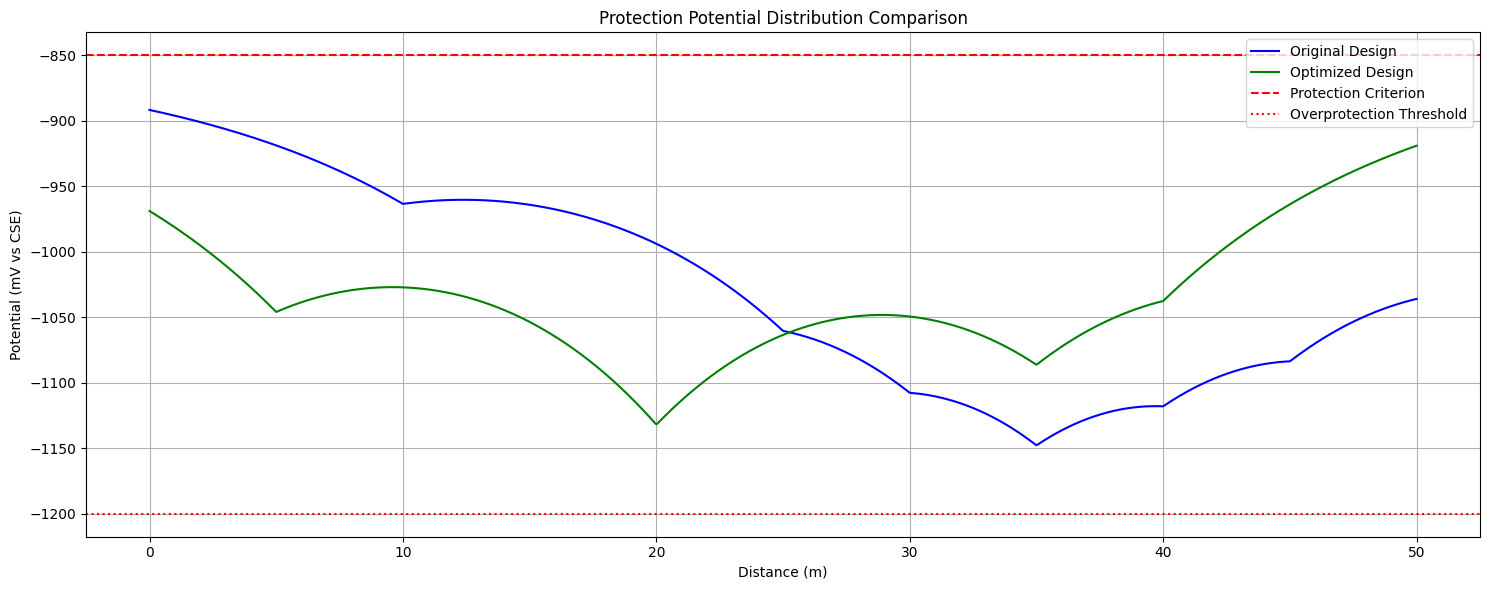


Design Comparison Summary:
                  Metric Original Design Optimized Design Improvement
 Optimally Protected (%)           100.0            100.0         0.0
     Under Protected (%)             0.0              0.0         0.0
      Over Protected (%)             0.0              0.0         0.0
  Average Potential (mV)         -1028.4          -1036.3         7.9
Potential Uniformity (%)            92.6             95.5         2.9


In [5]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

class PigStationICCP:
    def __init__(self, design_type="original"):
        # Station components dimensions (meters)
        self.launcher_length = 15.0
        self.receiver_length = 15.0
        self.underground_pipeline_length = 50.0
        self.pipe_diameter = 1.219  # 48 inches converted to meters

        if design_type == "original":
            # Original anode positions
            self.anodes = {
                'TR-A1': (10, 3.5),     # First point on receiver line
                'TR-A2': (30, 3.5),   # Middle point on receiver dip
                'TR-A3': (35, 3),   # End of receiver dip
                'TR-A4': (25, 1.5),     # On launcher line
                'TR-A5': (35, 1.5),     # Before launcher bend
                'TR-A6': (45, 1.5),     # On launcher end
                'TR-A7': (50, 1),     # Disconnected point
                'TR-A8': (40, -0.5)      # On underground pipeline vertical connection
            }
        else:
            # Optimized anode positions based on current distribution analysis
            self.anodes = {
                'TR-A1': (5, 4),      # Beginning of receiver for better edge protection
                'TR-A2': (20, 4),     # First third of receiver line
                'TR-A3': (35, 3.5),   # At receiver bend (critical area)
                'TR-A4': (5, 2),      # Beginning of launcher for better edge protection
                'TR-A5': (20, 2),     # First third of launcher line
                'TR-A6': (35, 2.5),   # At launcher bend (critical area)
                'TR-A7': (20, 0),     # Underground pipeline for balanced distribution
                'TR-A8': (40, 0)      # Near vertical connection (critical junction)
            }

        # Add anode material types
        self.anode_materials = {
            'TR-A1': 'MMO-Ti',
            'TR-A2': 'MMO-Ti',
            'TR-A3': 'MMO-Ti',
            'TR-A4': 'MMO-Ti',
            'TR-A5': 'MMO-Ti',
            'TR-A6': 'MMO-Ti',
            'TR-A7': 'MMO-Ti',
            'TR-A8': 'MMO-Ti'
        }

        # Add anode properties
        self.anode_properties = {
            'MMO-Ti': {
                'current_capacity': 100,  # A/m²
                'design_life': 25,        # years
                'consumption_rate': 0.001, # kg/A-year
                'potential': -1600        # mV vs CSE
            }
        }

        # Add pipeline analysis parameters
        self.pipeline_parameters = {
            'coating_type': 'FBE',  # Fusion Bonded Epoxy
            'coating_efficiency': 0.85,  # 85% efficiency
            'wall_thickness': 0.0127,  # meters (0.5 inches)
            'operating_pressure': 70,   # bar
            'soil_resistivity': 2000,  # ohm-cm
            'temperature': 25,          # Celsius
            'age': 5                    # years
        }

        # Add reference electrodes for potential measurements
        self.ref_electrodes = {
            'Receiver': [5, 20, 35, 45],
            'Launcher': [5, 20, 35, 45],
            'Stationary': [10, 25, 40]
        }

        # Design type for labeling
        self.design_type = design_type

    def create_station_layout(self):
        fig, ax = plt.subplots(figsize=(15, 8))

        # Draw Pig Receiver with exact bends as per diagram - in bird's eye view
        receiver_x = [0, 30, 35, 40, 45, self.receiver_length + 45]
        receiver_y = [4, 4, 3.5, 3.5, 4, 4]
        ax.plot(receiver_x, receiver_y, 'b-', linewidth=2, label='Pig Receiver')

        # Draw Pig Launcher with exact bend - in bird's eye view
        launcher_x = [0, 30, 35, 40, self.launcher_length + 40]
        launcher_y = [2, 2, 2.5, 2, 2]
        ax.plot(launcher_x, launcher_y, 'g-', linewidth=2, label='Pig Launcher')

        # Draw Stationary Pipeline - in bird's eye view
        ax.plot([0, self.underground_pipeline_length], [0, 0], 'r-',
                linewidth=2, label='Stationary Pipeline')

        # Draw vertical connection as a perpendicular line in bird's eye view
        ax.plot([40, 40], [0, 4], 'k-', linewidth=2, label='Vertical Connection')

        # Plot anodes with circles and dotted connection lines
        for anode_name, (x, y) in self.anodes.items():
            circle = plt.Circle((x, y), 0.5, fill=False)
            ax.add_patch(circle)
            ax.text(x, y, anode_name, ha='center', va='center')

            # Draw dotted connection line to nearest pipeline
            if y > 3:  # Upper anodes connect to receiver
                nearest_y = np.interp(x, receiver_x, receiver_y)
                ax.plot([x, x], [y, nearest_y], 'k:', linewidth=1)
            elif y > 1:  # Middle anodes connect to launcher
                nearest_y = np.interp(x, launcher_x, launcher_y)
                ax.plot([x, x], [y, nearest_y], 'k:', linewidth=1)
            else:  # Lower anodes connect to underground pipeline
                ax.plot([x, x], [y, 0], 'k:', linewidth=1)

        # Customize plot for bird's eye view
        ax.set_xlim(-2, self.underground_pipeline_length+5)
        ax.set_ylim(-1, 5)
        ax.set_title(f'Pig Station Layout with ICCP System ({self.design_type.capitalize()} Design)')
        ax.legend()
        ax.grid(True)
        ax.set_xlabel('Distance (meters)')
        ax.set_ylabel('Lateral Position (meters)')

        return fig, ax

    def calculate_potentials(self, x):
        """Calculate potential distribution along pipeline"""
        base = -850 * np.ones_like(x)

        # Influence factor
        influence_factor = 0.7

        for _, (anode_x, _) in self.anodes.items():
            # Simulate anode influence on potential with reduced factor
            influence = influence_factor * 100 * np.exp(-0.1 * np.abs(x - anode_x))
            base -= influence

        # Apply a limit to ensure potentials don't go below -1200 mV
        base = np.maximum(base, -1200)

        return base

    def simulate_soil_cp(self):
        """Simulate cathodic protection in soil environment"""
        # Create grid for simulation
        x = np.linspace(0, self.underground_pipeline_length, 200)
        y = np.linspace(-2, 6, 160)
        X, Y = np.meshgrid(x, y)

        # Initialize potential field
        potential = np.zeros_like(X)

        # Set base potential for pipelines
        pipeline_mask = (
            # Receiver pipeline
            ((Y >= 3.5) & (Y <= 4.5) & (X <= 45)) |
            # Launcher pipeline
            ((Y >= 1.5) & (Y <= 2.5) & (X <= 45)) |
            # Stationary pipeline
            ((Y >= -0.5) & (Y <= 0.5) & (X <= self.underground_pipeline_length)) |
            # Vertical connection
            ((X >= 39.5) & (X <= 40.5) & (Y <= 4) & (Y >= 0))
        )
        potential[pipeline_mask] = -0.85  # Base steel potential

        # Add anode influence with reduced factor
        soil_resistivity = self.pipeline_parameters['soil_resistivity']
        for anode_name, (anode_x, anode_y) in self.anodes.items():
            # Get anode material and properties
            material = self.anode_materials[anode_name]
            anode_potential = self.anode_properties[material]['potential'] / 1000  # Convert to V

            # Calculate distance from each point to anode
            distance = np.sqrt((X - anode_x)**2 + (Y - anode_y)**2)

            # Significantly reduce anode influence to prevent overprotection
            if material == 'MMO-Ti':
                influence_factor = 0.25
            else:
                influence_factor = 0.15

            influence = influence_factor * np.exp(-distance / (10 * np.sqrt(soil_resistivity/10000)))

            # Apply a maximum limit to the influence
            influence = np.minimum(influence, 0.5)

            potential -= influence

        # Apply a hard limit to ensure no values go below -1.2V
        potential = np.maximum(potential, -1.2)

        # Create figure for CP visualization with white background
        fig, ax = plt.subplots(figsize=(15, 8), facecolor='white')
        ax.set_facecolor('white')

        # Define professional color map and discrete levels for better visualization
        # Using a blue-green-yellow-red colormap similar to professional CP software
        custom_cmap = plt.cm.get_cmap('RdYlBu_r')

        # Define specific potential levels for more professional appearance
        levels = np.linspace(-1.2, -0.7, 15)

        # Plot potential contours with smoother interpolation and cleaner appearance
        contour = ax.contourf(X, Y, potential, levels=levels, cmap=custom_cmap, alpha=0.9)

        # Add contour lines for better readability
        contour_lines = ax.contour(X, Y, potential, levels=levels, colors='k', linewidths=0.5, alpha=0.3)

        # Add protection criterion line with more prominence
        protection_line = ax.contour(X, Y, potential, levels=[-0.85], colors='r',
                                    linestyles='--', linewidths=2.5)
        ax.clabel(protection_line, inline=True, fontsize=10, fmt='%1.2f V')

        # Add a more professional colorbar
        cbar = fig.colorbar(contour, ax=ax, pad=0.01)
        cbar.set_label('Potential (V vs CSE)', fontsize=12)
        cbar.ax.tick_params(labelsize=10)

        # Draw pipelines with thicker, more visible lines
        receiver_x = [0, 30, 35, 40, 45, self.receiver_length + 45]
        receiver_y = [4, 4, 3.5, 3.5, 4, 4]
        ax.plot(receiver_x, receiver_y, 'b-', linewidth=3, label='Pig Receiver')

        # Launcher pipeline
        launcher_x = [0, 30, 35, 40, self.launcher_length + 40]
        launcher_y = [2, 2, 2.5, 2, 2]
        ax.plot(launcher_x, launcher_y, 'g-', linewidth=3, label='Pig Launcher')

        # Stationary pipeline
        ax.plot([0, self.underground_pipeline_length], [0, 0], 'r-',
                linewidth=3, label='Stationary Pipeline')

        # Vertical connection
        ax.plot([40, 40], [0, 4], 'k-', linewidth=3, label='Vertical Connection')

        # Plot anodes with more professional markers
        for anode_name, (x, y) in self.anodes.items():
            ax.plot(x, y, 'o', color='blue', markersize=10, markeredgecolor='black',
                   markeredgewidth=1.5, zorder=5)
            ax.text(x+0.5, y+0.5, anode_name, fontsize=9, fontweight='bold',
                   bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

        # Add legend with better formatting
        legend = ax.legend(loc='upper right', framealpha=0.9, frameon=True,
                          fontsize=10, facecolor='white')
        legend.get_frame().set_edgecolor('gray')

        # Add grid with lighter appearance
        ax.grid(True, linestyle='--', alpha=0.3, color='gray')

        # Customize plot with more professional appearance
        ax.set_xlim(-2, self.underground_pipeline_length+5)
        ax.set_ylim(-2, 6)
        ax.set_title(f'Cathodic Protection Potential Distribution ({self.design_type.capitalize()} Design)',
                    fontsize=14, fontweight='bold', pad=10)
        ax.set_xlabel('Distance (meters)', fontsize=12)
        ax.set_ylabel('Lateral Position (meters)', fontsize=12)

        # Add border around the plot
        for spine in ax.spines.values():
            spine.set_linewidth(1.5)
            spine.set_color('black')

        # Rest of the hover functionality remains the same
        annot = ax.annotate("", xy=(0, 0), xytext=(10, 10),
                           textcoords="offset points",
                           bbox=dict(boxstyle="round", fc="white", alpha=0.9, ec="gray"),
                           arrowprops=dict(arrowstyle="->"))
        annot.set_visible(False)

        def hover(event):
            # Hover functionality code remains unchanged
            if event.inaxes == ax:
                x_val, y_val = event.xdata, event.ydata
                if x_val is not None and y_val is not None:
                    # Convert cursor position to array indices
                    x_range = x[-1] - x[0]
                    y_range = y[-1] - y[0]

                    # Calculate normalized position (0-1)
                    x_norm = (x_val - x[0]) / x_range
                    y_norm = (y_val - y[0]) / y_range

                    # Convert to indices
                    x_idx = int(x_norm * (len(x) - 1))
                    y_idx = int(y_norm * (len(y) - 1))

                    # Ensure indices are within bounds
                    x_idx = max(0, min(x_idx, len(x) - 1))
                    y_idx = max(0, min(y_idx, len(y) - 1))

                    # Get potential value (convert to mV for display)
                    pot_val = potential[y_idx, x_idx] * 1000

                    # Update annotation position and text
                    annot.xy = (x_val, y_val)
                    annot.set_text(f'Position: ({x_val:.2f}m, {y_val:.2f}m)\nPotential: {pot_val:.1f} mV')
                    annot.set_visible(True)
                    fig.canvas.draw_idle()
                else:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()
            else:
                annot.set_visible(False)
                fig.canvas.draw_idle()

        fig.canvas.mpl_connect('motion_notify_event', hover)

        return fig, ax, potential

    def simulate_current_distribution(self):
        """Simulate current distribution from anodes to pipeline structures"""
        # Create grid for simulation
        x = np.linspace(0, self.underground_pipeline_length, 200)
        y = np.linspace(-2, 6, 160)
        X, Y = np.meshgrid(x, y)

        # Initialize current field components
        current_x = np.zeros_like(X)
        current_y = np.zeros_like(Y)

        # Define pipeline locations for current flow calculation
        pipeline_points = []

        # Receiver pipeline points
        receiver_x = [0, 30, 35, 40, 45, self.receiver_length + 45]
        receiver_y = [4, 4, 3.5, 3.5, 4, 4]
        for i in range(100):
            t = i / 99
            idx = min(len(receiver_x) - 2, int(t * (len(receiver_x) - 1)))
            alpha = t * (len(receiver_x) - 1) - idx
            x_val = receiver_x[idx] * (1 - alpha) + receiver_x[idx + 1] * alpha
            y_val = receiver_y[idx] * (1 - alpha) + receiver_y[idx + 1] * alpha
            pipeline_points.append((x_val, y_val))

        # Launcher pipeline points
        launcher_x = [0, 30, 35, 40, self.launcher_length + 40]
        launcher_y = [2, 2, 2.5, 2, 2]
        for i in range(100):
            t = i / 99
            idx = min(len(launcher_x) - 2, int(t * (len(launcher_x) - 1)))
            alpha = t * (len(launcher_x) - 1) - idx
            x_val = launcher_x[idx] * (1 - alpha) + launcher_x[idx + 1] * alpha
            y_val = launcher_y[idx] * (1 - alpha) + launcher_y[idx + 1] * alpha
            pipeline_points.append((x_val, y_val))

        # Underground pipeline points
        for i in range(100):
            pipeline_points.append((i * self.underground_pipeline_length / 99, 0))

        # Vertical connection
        for i in range(40):
            pipeline_points.append((40, i / 39 * 4))

        # Calculate current vectors
        soil_resistivity = self.pipeline_parameters['soil_resistivity']
        conductivity = 1 / (soil_resistivity * 0.01)  # Convert ohm-cm to S/m

        for anode_name, (anode_x, anode_y) in self.anodes.items():
            # Get anode properties
            material = self.anode_materials[anode_name]
            current_capacity = self.anode_properties[material]['current_capacity']

            # Calculate current flow from this anode to all points
            for i in range(len(X)):
                for j in range(len(X[0])):
                    # Distance from anode to this point
                    dx = X[i, j] - anode_x
                    dy = Y[i, j] - anode_y
                    distance = np.sqrt(dx**2 + dy**2)

                    if distance < 0.1:  # Avoid division by zero
                        continue

                    # Current decreases with distance
                    current_magnitude = current_capacity * np.exp(-distance / 5) * conductivity

                    # Calculate direction components (from anode to pipeline)
                    # Find closest pipeline point
                    min_dist = float('inf')
                    closest_x, closest_y = 0, 0

                    for px, py in pipeline_points:
                        dist = np.sqrt((X[i, j] - px)**2 + (Y[i, j] - py)**2)
                        if dist < min_dist:
                            min_dist = dist
                            closest_x, closest_y = px, py

                    # Direction from current point to closest pipeline point
                    total_dist = np.sqrt((closest_x - anode_x)**2 + (closest_y - anode_y)**2)
                    if total_dist < 0.1:  # Avoid division by zero
                        continue

                    # Weight the current direction
                    weight = np.exp(-distance / total_dist)

                    # Direction from anode to pipeline through this point
                    dir_x = (closest_x - X[i, j]) / min_dist
                    dir_y = (closest_y - Y[i, j]) / min_dist

                    # Add to current field
                    current_x[i, j] += current_magnitude * dir_x * weight
                    current_y[i, j] += current_magnitude * dir_y * weight

        # Create figure for current distribution visualization
        fig, ax = plt.subplots(figsize=(15, 8))

        # Plot current vectors (streamplot)
        streamplot = ax.streamplot(X, Y, current_x, current_y, density=1, color=np.sqrt(current_x**2 + current_y**2),
                                  cmap='autumn', linewidth=1, arrowsize=1.5)
        cbar = fig.colorbar(streamplot.lines, ax=ax)
        cbar.set_label('Current Density (A/m²)')

        # Draw pipelines
        ax.plot(receiver_x, receiver_y, 'k-', linewidth=2, label='Pig Receiver')
        ax.plot(launcher_x, launcher_y, 'k-', linewidth=2, label='Pig Launcher')
        ax.plot([0, self.underground_pipeline_length], [0, 0], 'k-', linewidth=2, label='Stationary Pipeline')
        ax.plot([40, 40], [0, 4], 'k-', linewidth=2)

        # Plot anodes
        for anode_name, (x, y) in self.anodes.items():
            ax.plot(x, y, 'bo', markersize=8)
            ax.text(x+0.5, y+0.5, anode_name, fontsize=8)

        # Customize plot
        ax.set_xlim(-2, self.underground_pipeline_length+5)
        ax.set_ylim(-2, 6)
        ax.set_title(f'Current Distribution from MMO-Ti Anodes ({self.design_type.capitalize()} Design)')
        ax.legend()
        ax.grid(True)
        ax.set_xlabel('Distance (meters)')
        ax.set_ylabel('Lateral Position (meters)')

        return fig, ax, current_x, current_y

    def analyze_pipeline(self):
        """Analyze pipeline conditions and protection status"""
        # Calculate surface area
        total_length = self.launcher_length + self.receiver_length + self.underground_pipeline_length
        surface_area = np.pi * self.pipe_diameter * total_length

        # Calculate current density requirements
        base_current_density = 20  # mA/m² (typical for moderate conditions)
        total_current = surface_area * base_current_density * (1 - self.pipeline_parameters['coating_efficiency'])

        # Calculate protection metrics
        x = np.linspace(0, self.underground_pipeline_length, 1000)
        potentials = self.calculate_potentials(x)

        # Calculate protection metrics
        under_protected = np.sum(potentials > -850) / len(potentials) * 100
        over_protected = np.sum(potentials < -1200) / len(potentials) * 100
        optimally_protected = 100 - under_protected - over_protected

        # Create analysis report
        report = pd.DataFrame({
            "Parameter": [
                "Total Pipeline Length (m)",
                "Surface Area (m²)",
                "Required Current (mA)",
                "Soil Resistivity (ohm-cm)",
                "Coating Efficiency (%)",
                "Number of Anodes",
                "Average Protection Level (mV)",
                "Optimally Protected (%)",
                "Under Protected (%)",
                "Over Protected (%)"
            ],
            "Value": [
                f"{total_length:.1f}",
                f"{surface_area:.1f}",
                f"{total_current:.1f}",
                f"{self.pipeline_parameters['soil_resistivity']}",
                f"{self.pipeline_parameters['coating_efficiency']*100}",
                len(self.anodes),
                f"{np.mean(potentials):.1f}",
                f"{optimally_protected:.1f}",
                f"{under_protected:.1f}",
                f"{over_protected:.1f}"
            ]
        })

        return report

    def optimize_tr_settings(self):
        """Optimize transformer rectifier settings"""
        # Calculate surface area
        total_length = self.launcher_length + self.receiver_length + self.underground_pipeline_length
        surface_area = np.pi * self.pipe_diameter * total_length

        # Calculate current density requirements
        base_current_density = 20  # mA/m² (typical for moderate conditions)
        total_current = surface_area * base_current_density * (1 - self.pipeline_parameters['coating_efficiency'])

        # Calculate voltage requirements based on soil resistivity
        soil_resistivity = self.pipeline_parameters['soil_resistivity']
        voltage_factor = 0.5 + (soil_resistivity / 10000) * 0.5  # Scale with soil resistivity

        # Calculate optimal TR settings
        voltage = 24 * voltage_factor  # Base voltage adjusted by soil conditions
        current = total_current / 1000 * 1.2  # Convert to A and add 20% safety factor

        # Calculate power requirements
        power = voltage * current

        # Return optimized settings
        return {
            "Voltage (V)": f"{voltage:.1f}",
            "Current (A)": f"{current:.2f}",
            "Power (W)": f"{power:.1f}",
            "Anodes": f"{len(self.anodes)}",
            "Soil Resistivity (ohm-cm)": f"{soil_resistivity}"
        }

    def display_analysis(self):
        """Display comprehensive pipeline analysis"""
        report = self.analyze_pipeline()
        tr_specs = self.optimize_tr_settings()

        # Plot current layout
        layout_fig, layout_ax = self.create_station_layout()
        plt.figure(layout_fig.number)
        plt.tight_layout()
        plt.show()

        # Run soil CP simulation
        cp_fig, cp_ax, potential = self.simulate_soil_cp()
        plt.figure(cp_fig.number)
        plt.tight_layout()
        plt.show()

        # Run current distribution simulation
        current_fig, current_ax, current_x, current_y = self.simulate_current_distribution()
        plt.figure(current_fig.number)
        plt.tight_layout()
        plt.show()

        # Create analysis figure
        fig, ax = plt.subplots(figsize=(15, 6))

        # Plot Protection Potential Distribution
        x = np.linspace(0, self.underground_pipeline_length, 1000)
        potentials = self.calculate_potentials(x)
        line, = ax.plot(x, potentials, 'b-', label='Protection Potential')
        ax.axhline(y=-850, color='r', linestyle='--', label='Protection Criterion')
        ax.axhline(y=-1200, color='r', linestyle=':', label='Overprotection Threshold')
        ax.set_xlabel('Distance (m)')
        ax.set_ylabel('Potential (mV vs CSE)')
        ax.set_title(f'Protection Potential Distribution ({self.design_type.capitalize()} Design)')
        ax.grid(True)
        ax.legend()

        # Add mouse hover functionality
        annot = ax.annotate("", xy=(0,0), xytext=(20,20),
                            textcoords="offset points",
                            bbox=dict(boxstyle="round", fc="white", alpha=0.8),
                            arrowprops=dict(arrowstyle="->"))
        annot.set_visible(False)

        def update_annot(ind):
            x_pos = x[ind["ind"][0]]
            y_pos = potentials[ind["ind"][0]]
            annot.xy = (x_pos, y_pos)
            text = f"Distance: {x_pos:.2f}m\nPotential: {y_pos:.2f}mV"
            annot.set_text(text)
            annot.get_bbox_patch().set_alpha(0.8)

        def hover(event):
            vis = annot.get_visible()
            if event.inaxes == ax:
                cont, ind = line.contains(event)
                if cont:
                    update_annot(ind)
                    annot.set_visible(True)
                    fig.canvas.draw_idle()
                else:
                    if vis:
                        annot.set_visible(False)
                        fig.canvas.draw_idle()

        fig.canvas.mpl_connect("motion_notify_event", hover)

        plt.tight_layout()
        plt.show()

        # Display reports
        print(f"\nPipeline Analysis Report ({self.design_type.capitalize()} Design):")
        print(report.to_string(index=False))

        print(f"\nTransformer Rectifier Specifications ({self.design_type.capitalize()} Design):")
        tr_df = pd.DataFrame({"Parameter": list(tr_specs.keys()),
                             "Value": list(tr_specs.values())})
        print(tr_df.to_string(index=False))

        return report, potential, current_x, current_y


def compare_designs():
    """Compare original and optimized designs"""
    # Create instances of both designs
    original = PigStationICCP(design_type="original")
    optimized = PigStationICCP(design_type="optimized")

    # Get analysis reports
    original_report, original_potential, original_current_x, original_current_y = original.display_analysis()
    optimized_report, optimized_potential, optimized_current_x, optimized_current_y = optimized.display_analysis()

    # Create comparison figure for potentials
    fig, ax = plt.subplots(figsize=(15, 6))

    # Plot Protection Potential Distribution for both designs
    x = np.linspace(0, original.underground_pipeline_length, 1000)
    original_potentials = original.calculate_potentials(x)
    optimized_potentials = optimized.calculate_potentials(x)

    line_orig, = ax.plot(x, original_potentials, 'b-', label='Original Design')
    line_opt, = ax.plot(x, optimized_potentials, 'g-', label='Optimized Design')
    ax.axhline(y=-850, color='r', linestyle='--', label='Protection Criterion')
    ax.axhline(y=-1200, color='r', linestyle=':', label='Overprotection Threshold')
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('Potential (mV vs CSE)')
    ax.set_title('Protection Potential Distribution Comparison')
    ax.grid(True)
    ax.legend()

    # Add mouse hover functionality for comparison plot with improved display
    annot = ax.annotate("", xy=(0,0), xytext=(20,20),
                        textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="white", alpha=0.8),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(ind, line, design_type):
        x_pos = x[ind["ind"][0]]
        if line == line_orig:
            y_pos = original_potentials[ind["ind"][0]]
            design = "Original"
        else:
            y_pos = optimized_potentials[ind["ind"][0]]
            design = "Optimized"
        annot.xy = (x_pos, y_pos)
        text = f"{design} Design\nDistance: {x_pos:.2f}m\nPotential: {y_pos:.2f}mV"
        annot.set_text(text)
        annot.get_bbox_patch().set_alpha(0.8)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            for line, design in [(line_orig, "Original"), (line_opt, "Optimized")]:
                cont, ind = line.contains(event)
                if cont:
                    update_annot(ind, line, design)
                    annot.set_visible(True)
                    fig.canvas.draw_idle()
                    return
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)

    plt.tight_layout()
    plt.show()

    # Calculate improvement metrics
    # In display_analysis function
    # Calculate improvement metrics
    original_under = np.sum(original_potentials > -850) / len(original_potentials) * 100
    original_over = np.sum(original_potentials < -1200) / len(original_potentials) * 100
    original_optimal = 100 - original_under - original_over

    optimized_under = np.sum(optimized_potentials > -850) / len(optimized_potentials) * 100
    optimized_over = np.sum(optimized_potentials < -1200) / len(optimized_potentials) * 100
    optimized_optimal = 100 - optimized_under - optimized_over

    # Create comparison report
    comparison = pd.DataFrame({
        "Metric": [
            "Optimally Protected (%)",
            "Under Protected (%)",
            "Over Protected (%)",
            "Average Potential (mV)",
            "Potential Uniformity (%)"
        ],
        "Original Design": [
            f"{original_optimal:.1f}",
            f"{original_under:.1f}",
            f"{original_over:.1f}",
            f"{np.mean(original_potentials):.1f}",
            f"{(1 - np.std(original_potentials) / np.abs(np.mean(original_potentials))) * 100:.1f}"
        ],
        "Optimized Design": [
            f"{optimized_optimal:.1f}",
            f"{optimized_under:.1f}",
            f"{optimized_over:.1f}",
            f"{np.mean(optimized_potentials):.1f}",
            f"{(1 - np.std(optimized_potentials) / np.abs(np.mean(optimized_potentials))) * 100:.1f}"
        ],
        "Improvement": [
            f"{optimized_optimal - original_optimal:.1f}",
            f"{original_under - optimized_under:.1f}",
            f"{original_over - optimized_over:.1f}",
            f"{np.abs(np.mean(optimized_potentials)) - np.abs(np.mean(original_potentials)):.1f}",
            f"{((1 - np.std(optimized_potentials) / np.abs(np.mean(optimized_potentials))) - (1 - np.std(original_potentials) / np.abs(np.mean(original_potentials)))) * 100:.1f}"
        ]
    })

    print("\nDesign Comparison Summary:")
    print(comparison.to_string(index=False))

    return comparison


if __name__ == "__main__":
    compare_designs()